In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import os
import cv2

In [2]:
class train_data(Dataset):
    
    def __init__(self, transform=None):
        self.transform = transform
        directory = r"C:\Users\sivav\Edges"
        categories = ['Horizontal', 'Vertical']
        data = []
        labels = []

        for category in categories:
            path = os.path.join(directory, category)
            for img in os.listdir(path):
                img_path = os.path.join(path, img)
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                data.append(image)
                if(category == 'Horizontal'):
                    labels.append(0)
                else:
                    labels.append(1)
            
        data = np.asarray(data)
        labels = np.asarray(labels)
        labels = labels.reshape((10000,1))
        
        self.labels = labels
        self.images = data

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = Image.fromarray(self.images[idx])
        
        if self.transform:
            img = self.transform(img)

        return img, int(label)

In [3]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=0.5, std=0.5)
])
dataset = train_data(transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(2, 2)
        
        self.model = nn.Sequential(
            nn.Linear(66, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 64)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(2, 2)
        
        self.model = nn.Sequential(
            nn.Linear(102, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 64),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 8, 8)

In [6]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)

In [7]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 2, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()

In [8]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())   
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 2, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

Epoch 0
g_loss: 2.6790223121643066, d_loss: 0.3713282346725464


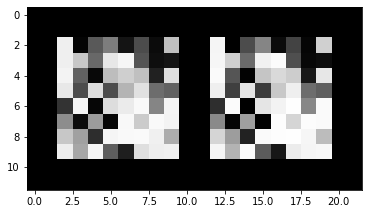

Epoch 1
g_loss: 2.057213306427002, d_loss: 0.48162224888801575


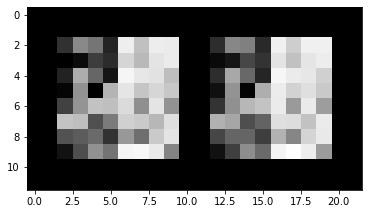

Epoch 2
g_loss: 2.1601431369781494, d_loss: 0.9274666905403137


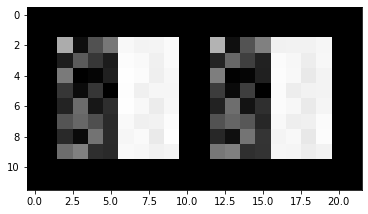

Epoch 3
g_loss: 1.3319201469421387, d_loss: 0.8597674369812012


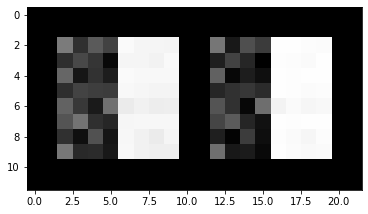

Epoch 4
g_loss: 1.8525516986846924, d_loss: 0.6687329411506653


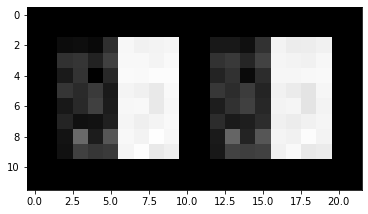

Epoch 5
g_loss: 2.1226134300231934, d_loss: 0.8541551828384399


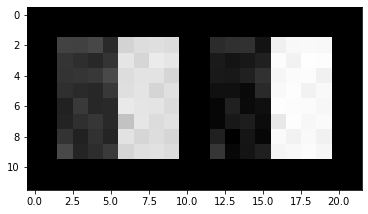

Epoch 6
g_loss: 2.5485680103302, d_loss: 0.6704414486885071


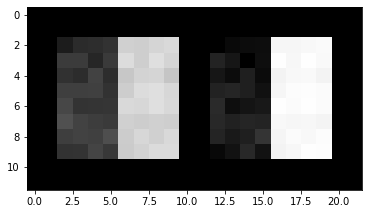

Epoch 7
g_loss: 2.806204319000244, d_loss: 0.7967275977134705


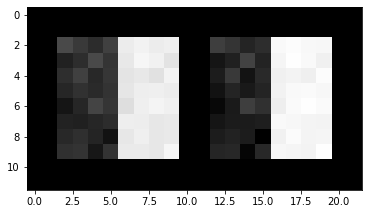

Epoch 8
g_loss: 2.511409044265747, d_loss: 0.549578845500946


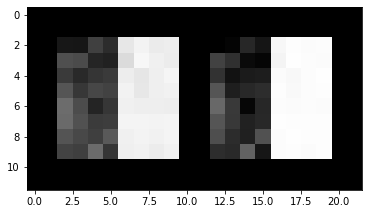

Epoch 9
g_loss: 2.8943138122558594, d_loss: 0.7830339670181274


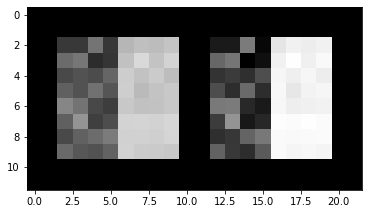

Epoch 10
g_loss: 4.4948930740356445, d_loss: 0.4020616114139557


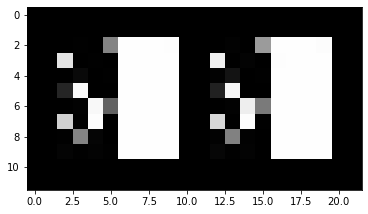

Epoch 11
g_loss: 2.9005210399627686, d_loss: 1.027427315711975


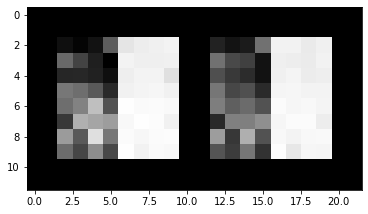

Epoch 12
g_loss: 2.4760611057281494, d_loss: 0.68426513671875


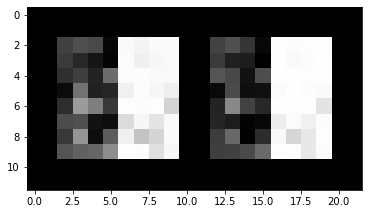

Epoch 13
g_loss: 3.6661999225616455, d_loss: 0.6379039287567139


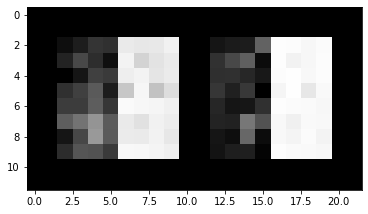

Epoch 14
g_loss: 1.112882375717163, d_loss: 1.1957980394363403


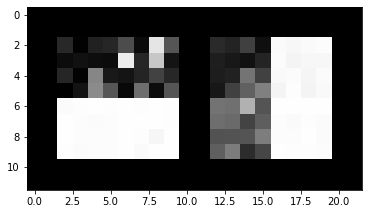

Epoch 15
g_loss: 1.2981986999511719, d_loss: 0.7317652106285095


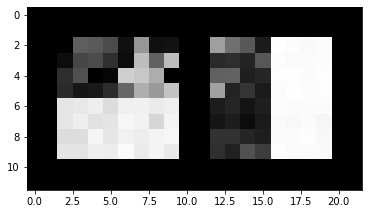

Epoch 16
g_loss: 1.5080567598342896, d_loss: 0.7817063331604004


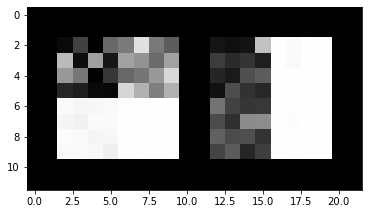

Epoch 17
g_loss: 1.1885814666748047, d_loss: 1.0284550189971924


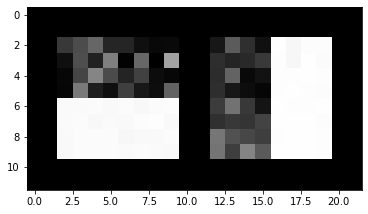

Epoch 18
g_loss: 0.7130500078201294, d_loss: 1.4607266187667847


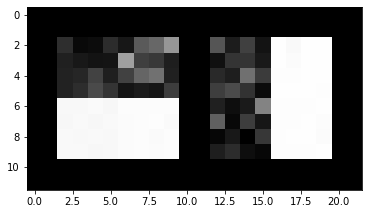

Epoch 19
g_loss: 0.8139268159866333, d_loss: 1.6399005651474


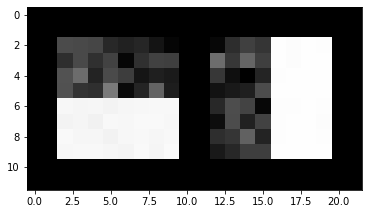

Epoch 20
g_loss: 1.285463571548462, d_loss: 1.1919342279434204


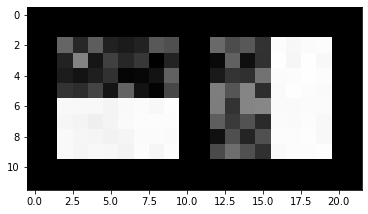

Epoch 21
g_loss: 0.8175090551376343, d_loss: 1.1343915462493896


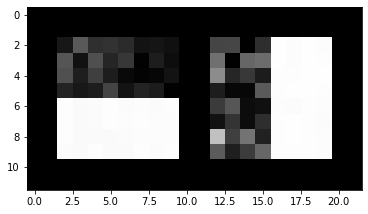

Epoch 22
g_loss: 1.6808862686157227, d_loss: 0.6949609518051147


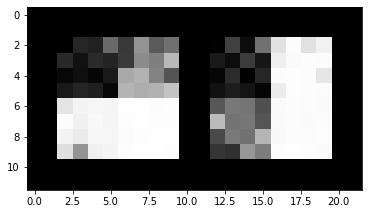

Epoch 23
g_loss: 1.1228363513946533, d_loss: 1.3160293102264404


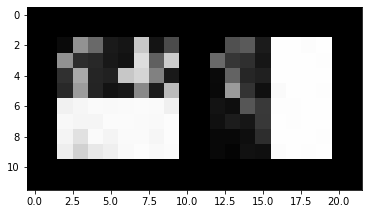

Epoch 24
g_loss: 1.1525201797485352, d_loss: 1.0517895221710205


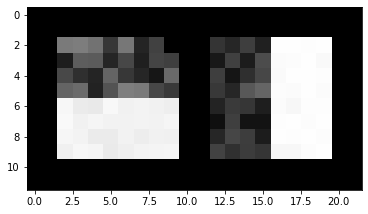

Epoch 25
g_loss: 0.867979884147644, d_loss: 1.2608281373977661


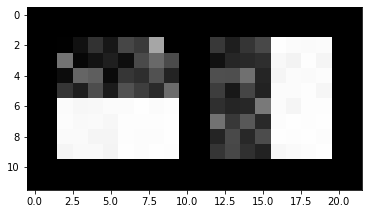

Epoch 26
g_loss: 0.8583148121833801, d_loss: 1.2460910081863403


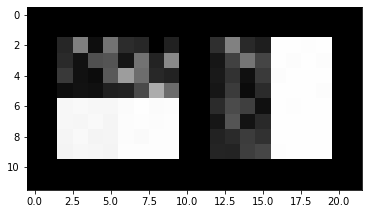

Epoch 27
g_loss: 0.8648020029067993, d_loss: 1.0262073278427124


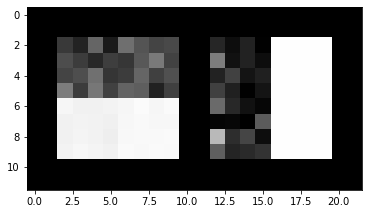

Epoch 28
g_loss: 1.0446534156799316, d_loss: 0.8811039924621582


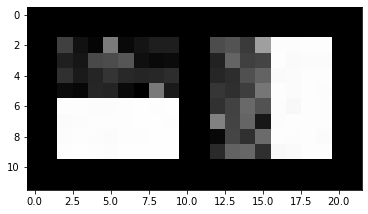

Epoch 29
g_loss: 0.9295107126235962, d_loss: 1.2536916732788086


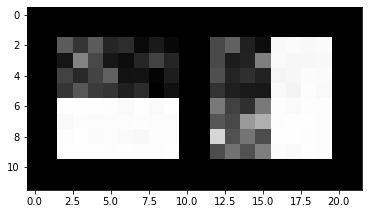

Epoch 30
g_loss: 1.2979931831359863, d_loss: 0.8543882369995117


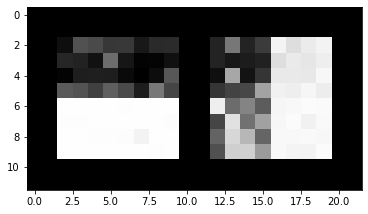

Epoch 31
g_loss: 1.497267723083496, d_loss: 0.8718317747116089


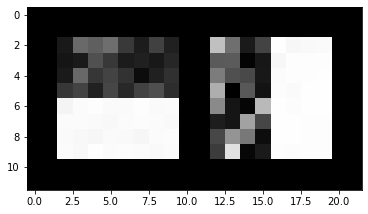

Epoch 32
g_loss: 0.8678970336914062, d_loss: 1.1102910041809082


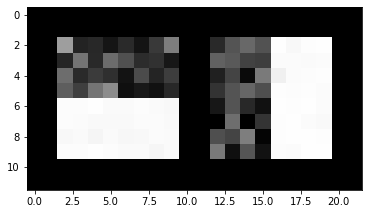

Epoch 33
g_loss: 1.2200586795806885, d_loss: 0.7326189279556274


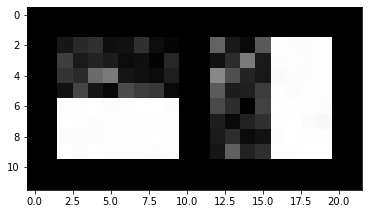

Epoch 34
g_loss: 0.9187259674072266, d_loss: 1.2993581295013428


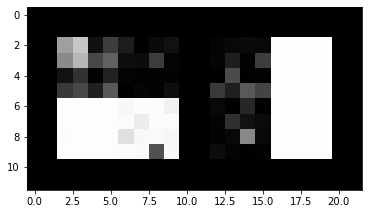

Epoch 35
g_loss: 1.0456929206848145, d_loss: 0.9865235686302185


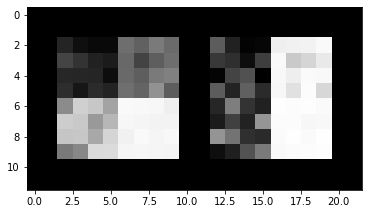

Epoch 36
g_loss: 0.9556087851524353, d_loss: 0.7705991268157959


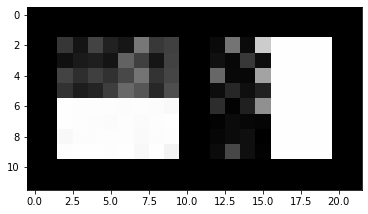

Epoch 37
g_loss: 1.1224522590637207, d_loss: 0.837914228439331


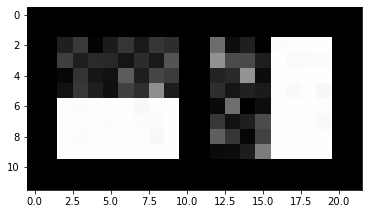

Epoch 38
g_loss: 0.9864388704299927, d_loss: 1.2525854110717773


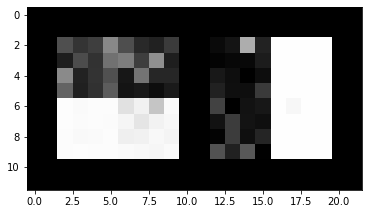

Epoch 39
g_loss: 1.4800828695297241, d_loss: 1.0204821825027466


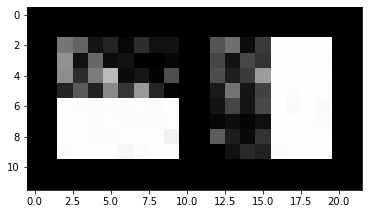

Epoch 40
g_loss: 0.9669147729873657, d_loss: 1.2048345804214478


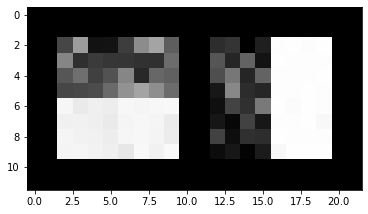

Epoch 41
g_loss: 1.0280293226242065, d_loss: 1.2121732234954834


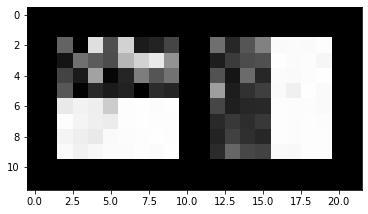

Epoch 42
g_loss: 0.8508386611938477, d_loss: 1.0387327671051025


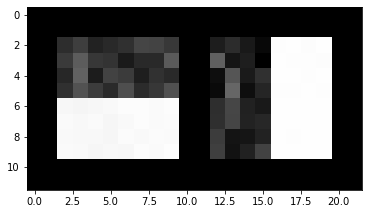

Epoch 43
g_loss: 1.074291467666626, d_loss: 0.7191197872161865


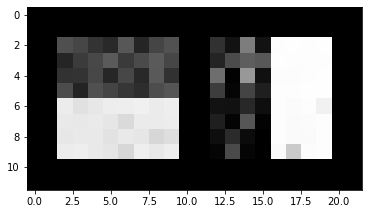

Epoch 44
g_loss: 1.8214800357818604, d_loss: 0.6654662489891052


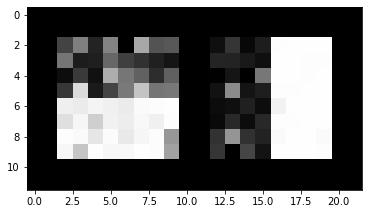

Epoch 45


In [ ]:
num_epochs = 50
for epoch in range(num_epochs):
    print('Epoch {}'.format(epoch))
    for i, (images, labels) in enumerate(data_loader):
        real_images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

    generator.eval()
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    z = Variable(torch.randn(2, 100)).cuda()
    labels = Variable(torch.LongTensor(np.arange(2))).cuda()
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

In [ ]:
z = Variable(torch.randn(10, 100)).cuda()
labels = Variable(torch.LongTensor([i for _ in range(5) for i in range(2)])).cuda()
sample_images = generator(z, labels).unsqueeze(1).data.cpu()
grid = make_grid(sample_images, nrow=2, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
_ = plt.yticks([])
_ = plt.xticks(np.arange(5,25,10),['Horizontal', 'Vertical'])
